NBA Player Analysis
--------------------------
Fetches, compares, and visualizes NBA player statistics using the `nba_api`.

Features:
    - Fuzzy name matching to handle typos and partial names
    - Pulls live player game logs for a given season
    - Generates average statistics and performance summaries
    - Highlights best players in each category
    - Produces bar charts, line plots, and box plots for visual analysis
    - Saves comparison summary to CSV

In [12]:
# pip install nba_api

In [13]:
import os
import warnings
import difflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
# Suppress specific urllib3 warnings (common when using `nba_api`)
warnings.filterwarnings("ignore", category=UserWarning, module="urllib3")

## Function: getFuzzyPlayerID

Finds the closest matching NBA player based on user input using fuzzy string matching.

# Args:
    input_name (str): The player's name as typed by the user.

# Returns:
    tuple: (player_id, full_name) if a match is found, else (None, None).

In [14]:
def getFuzzyPlayerID(input_name):
    all_players = players.get_players()
    player_names = [p['full_name'] for p in all_players]

    # Allow low cutoff to capture spelling errors or abbreviations
    close_matches = difflib.get_close_matches(input_name, player_names, n=5, cutoff=0.3)

    if not close_matches:
        print(f"No close match found for '{input_name}'")
        return None, None

    # Show suggestions to the user
    print("\nDid you mean:")
    for idx, name in enumerate(close_matches, start=1):
        print(f"{idx}. {name}")

    # Prompt until a valid choice is made
    while True:
        try:
            choice = int(input("Enter the number of the correct player: "))
            if 1 <= choice <= len(close_matches):
                selected_name = close_matches[choice - 1]
                selected_player = next(p for p in all_players if p['full_name'] == selected_name)
                return selected_player['id'], selected_player['full_name']
            else:
                print("Please enter a valid number from the list.")
        except (ValueError, IndexError, StopIteration):
            print("Invalid selection. Please try again.")

## Function: prompt_and_resolve_players

Prompts the user for how many players to compare and resolves their names using fuzzy matching.

# Returns:
    list: List of tuples (player_id, actual_name) for each confirmed player.

In [15]:
def prompt_and_resolve_players():
    while True:
        try:
            player_count = int(input("How many players would you like to compare: "))
            if player_count <= 0:
                print("Please enter a positive integer.")
                continue
            break
        except ValueError:
            print("Invalid number. Try again.")

    resolved_players = []
    for i in range(player_count):
        while True:
            raw_name = input(f"Enter full name for player {i + 1}: ").strip()
            player_id, actual_name = getFuzzyPlayerID(raw_name)
            if player_id:
                resolved_players.append((player_id, actual_name))
                break
            else:
                print("Couldn't resolve player. Please try again.")
    return resolved_players

## Function: fetch_player_data

Fetches player game logs for a given season and calculates custom metrics.

# Args:
    resolved_players (list): List of (player_id, name) tuples.
    season (str): NBA season in 'YYYY-YY' format. Default: '2024-25'.

# Returns:
    dict: Dictionary where keys are player names and values are DataFrames of game stats.

In [16]:
def fetch_player_data(resolved_players, season="2024-25"):
    player_data = {}
    for player_id, actual_name in resolved_players:
        gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season)
        df = gamelog.get_data_frames()[0]

        # Convert and sort dates
        df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
        df.sort_values('GAME_DATE', inplace=True)

        # Add custom metrics
        df['TOTAL_IMPACT'] = df['PTS'] + df['AST'] + df['REB']
        df['FG_PCT'] = np.where(df['FGA'] != 0, df['FGM'] / df['FGA'], 0)

        player_data[actual_name] = df

    print("Players included in summary:", list(player_data.keys()))
    return player_data


## Function: summary

Creates a DataFrame summarizing average points, assists, rebounds, and FG% per player.

# Args:
    player_data (dict): Player names mapped to their game logs.

# Returns:
    pd.DataFrame: Summary of average stats for all players.

In [17]:
def summary(player_data):
    comparison_summary = []
    for name, df in player_data.items():
        avg_pts = df['PTS'].mean()
        avg_ast = df['AST'].mean()
        avg_reb = df['REB'].mean()
        fg_pct = df['FG_PCT'].mean() * 100
        comparison_summary.append({
            'Player': name,
            'Avg Pts': round(avg_pts, 2),
            'Avg Assists': round(avg_ast, 2),
            'Avg Rebounds': round(avg_reb, 2),
            'Avg FG%': f"{round(fg_pct, 1)}%"
        })
    return pd.DataFrame(comparison_summary)

## Function: key_findings

Highlights best players in each category from the summary stats.

# Args:
    player_data (dict): Player names mapped to their game logs.
    summary_df (pd.DataFrame): Summary of average stats.

# Returns:
    list: List of key finding strings.

In [18]:
def key_findings(player_data, summary_df):
    findings = []

    # Best scorer
    best_scorer = summary_df.loc[summary_df['Avg Pts'].idxmax()]['Player']
    scorer_val = summary_df['Avg Pts'].max()
    findings.append(f"Best scorer: {best_scorer} ({scorer_val:.2f} PPG)")

    # Best passer
    best_passer = summary_df.loc[summary_df['Avg Assists'].idxmax()]['Player']
    passer_val = summary_df['Avg Assists'].max()
    findings.append(f"Best playmaker: {best_passer} ({passer_val:.2f} APG)")

    # Best rebounder
    best_rebounder = summary_df.loc[summary_df['Avg Rebounds'].idxmax()]['Player']
    rebounder_val = summary_df['Avg Rebounds'].max()
    findings.append(f"Best rebounder: {best_rebounder} ({rebounder_val:.2f} RPG)")

    # Most efficient shooter
    best_fg = summary_df.loc[
        summary_df['Avg FG%'].str.rstrip('%').astype(float).idxmax()
    ]['Player']
    fg_val = summary_df['Avg FG%'].str.rstrip('%').astype(float).max()
    findings.append(f"Most efficient shooter: {best_fg} ({fg_val:.1f}%)")

    # Most consistent scorer
    pts_stds = {name: df['PTS'].std() for name, df in player_data.items() if len(df) > 1}
    if pts_stds:
        most_consistent = min(pts_stds, key=pts_stds.get)
        findings.append(f"Most consistent scorer: {most_consistent} (std dev: {pts_stds[most_consistent]:.2f})")

    return findings

## Visualize

Generates bar charts, line plots, and box plots for player comparisons.

# Args:
    data (dict): Player names mapped to DataFrames of game logs.
    summary (pd.DataFrame): Summary of average stats.

In [19]:
def visualize(data, summary):
    palette = sns.color_palette("Set2", n_colors=len(summary['Player']))

    # Bar chart: Avg points, assists, rebounds
    plt.figure(figsize=(10, 6))
    metrics = ['Avg Pts', 'Avg Assists', 'Avg Rebounds']
    x = np.arange(len(summary['Player']))
    bar_width = 0.25
    for i, metric in enumerate(metrics):
        plt.bar(x + i * bar_width, summary[metric], width=bar_width,
                label=metric, color=palette[i % len(palette)])
    plt.xticks(x + bar_width, summary['Player'])
    plt.xlabel("Players")
    plt.ylabel("Average per Game")
    plt.title("Player Comparison: Avg Pts, Assists, Rebounds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Line plot: Points over season
    plt.figure(figsize=(10, 6))
    for idx, (name, df) in enumerate(data.items()):
        if not df.empty:
            sns.lineplot(x=df['GAME_DATE'], y=df['PTS'], label=name, color=palette[idx])
    plt.title('Points Over Season')
    plt.xlabel('Game Date')
    plt.ylabel('Points')
    plt.legend()
    plt.show()

    # Box plot: Total impact
    all_impact = [pd.DataFrame({'Player': name, 'Impact': df['TOTAL_IMPACT']})
                  for name, df in data.items() if not df.empty]
    if all_impact:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=pd.concat(all_impact), x='Player', y='Impact',
                    hue='Player', palette=palette, legend=False)
        plt.title('Total Impact Distribution')
        plt.show()

    # Bar plot: Games played
    games_counts = {name: len(df) for name, df in data.items()}
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(games_counts.keys()), y=list(games_counts.values()),
                hue=list(games_counts.keys()), palette=palette, legend=False)
    plt.title('Games Played')
    plt.xlabel('Player')
    plt.ylabel('Games')
    plt.show()

## Function: save_summary

Saves the player comparison summary to CSV.

# Args:
    summary_df (pd.DataFrame): Summary statistics.
    output_dir (str): Directory to save the file.

In [20]:
def save_summary(summary_df, output_dir="output"):
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "player_comparison.csv")
    summary_df.to_csv(output_path, index=False)

🏀 NBA Player Comparison 🏀

Did you mean:
1. Stephen Curry
2. Seth Curry
3. Stephon Marbury
4. Stephen Bardo
5. Stephen Howard

Did you mean:
1. LeBron James
2. Aaron James
3. Jerome James
4. Bronny James
5. Gene James

Did you mean:
1. Luka Dončić
2. Luka Samanic
3. Juan Dixon
4. Luke Walton
5. Luke Kornet

Did you mean:
1. Nikola Jokić
2. Nikola Jović
3. Nikola Pekovic
4. Nikola Mirotic
5. Nikola Topić
Players included in summary: ['Stephen Curry', 'LeBron James', 'Luka Dončić', 'Nikola Jokić']

Player Comparison Summary:
           Player  Avg Pts  Avg Assists  Avg Rebounds Avg FG%
0  Stephen Curry    24.54         6.01          4.43   44.5%
1   LeBron James    24.43         8.21          7.80   51.1%
2    Luka Dončić    28.16         7.66          8.18   44.9%
3   Nikola Jokić    29.59        10.23         12.74   58.5%

Key Findings:
- Best scorer: Nikola Jokić (29.59 PPG)
- Best playmaker: Nikola Jokić (10.23 APG)
- Best rebounder: Nikola Jokić (12.74 RPG)
- Most efficient shooter

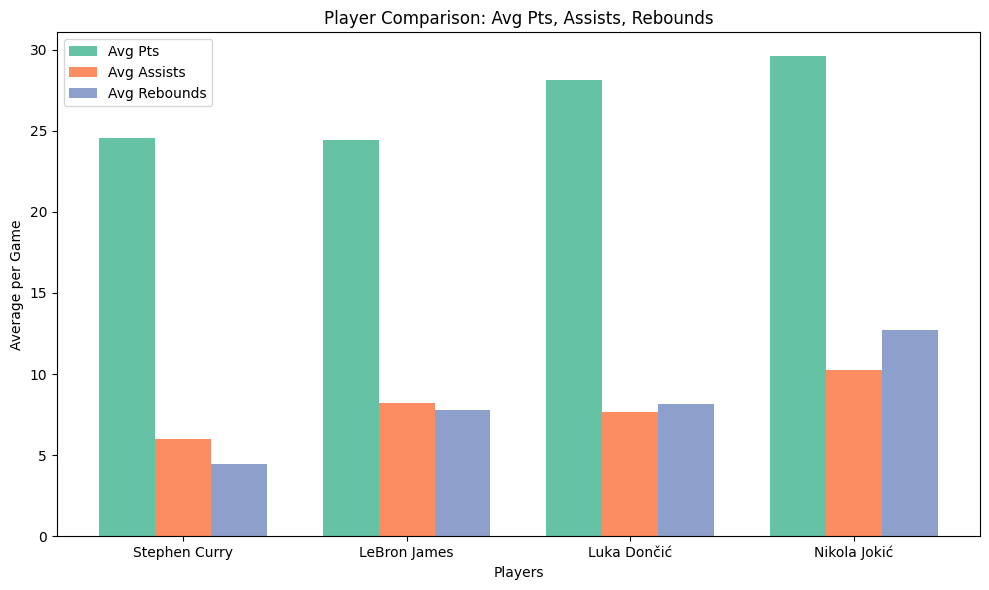

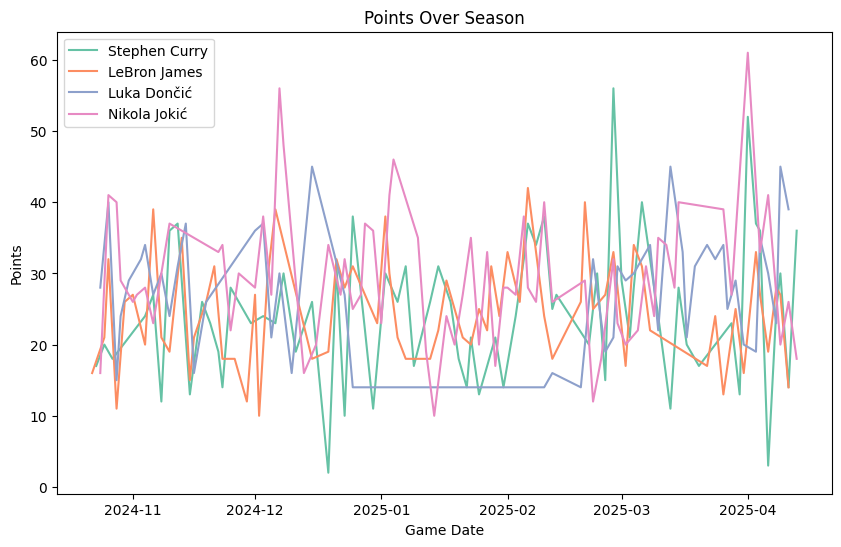

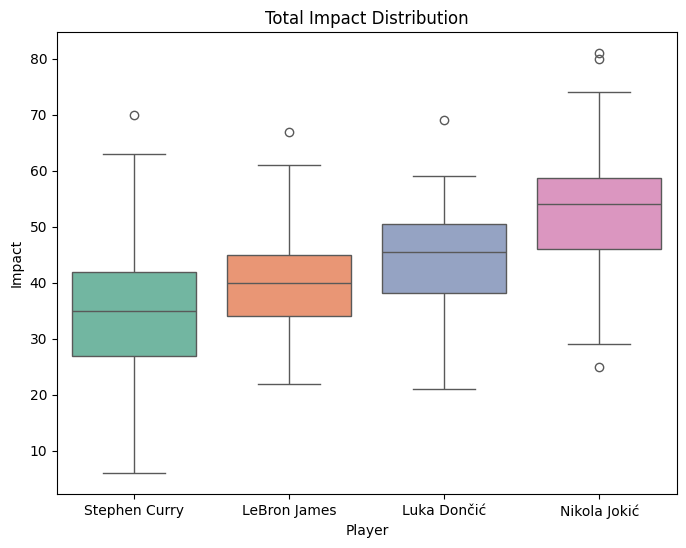

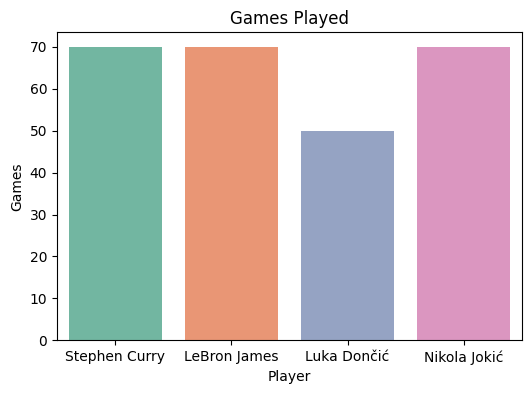

In [21]:
# Main Program
def main():
    print("🏀 NBA Player Comparison 🏀")
    resolved_players = prompt_and_resolve_players()
    player_data = fetch_player_data(resolved_players)
    summary_df = summary(player_data)

    print("\nPlayer Comparison Summary:\n", summary_df)

    save_summary(summary_df)

    print("\nKey Findings:")
    for finding in key_findings(player_data, summary_df):
        print("-", finding)

    visualize(player_data, summary_df)

if __name__ == "__main__":
    main()